# Imports

In [1]:
import acquire
import prepare
import encode
import evaluate_models
import features
import model

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Acquire

In [2]:
telco = acquire.get_telco_data()

In [3]:
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,No,No,No,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,No,Yes,No,No,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,No phone service,No,No,No,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,Yes,No,No,No,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


# Prepare

In [4]:
train, test, validate = prepare.prep_telco(telco, train_size=.8, seed=123)

# Add Features From Feature Engineering

In [5]:
train, test, validate = features.auto_payment(train, test, validate)

In [6]:
train, test, validate = features.has_internet(train, test, validate)

## Encode

In [7]:
encoded_train, encoded_test, encoded_validate = encode.create_encoded_dfs(train, test, validate)

# Modeling

In [8]:
# Create a Function that returns the DF every time
def get_clean_df(train, validate):
    cols = ['tenure', 'contract_type', 'monthly_charges', 
            'senior_citizen', 'payment_type', 'churn',
            'phone_lines', 'dependent_partner_grouping',
            'partner', 'dependents', 'automatic_payment',
            'tenure_years', 'online_security', 'tech_support',
            'has_internet', 'internet_service_type', 'streaming_tv',
            'streaming_movies', 'device_protection']
    
    t = train[cols]
    v = validate[cols]
    
    return t, v

In [9]:
predictions = pd.DataFrame({'actual': encoded_validate.churn})

## Logistic Regregression

### First Log Model

In [10]:
t, v = get_clean_df(encoded_train, encoded_validate)

In [11]:
cols = ['contract_type', 
        'tenure',
        'monthly_charges',
        'automatic_payment']

X_train, X_validate = t[cols], v[cols]
y_train, y_validate = t.churn, v.churn

log_1 = LogisticRegression().fit(X_train, y_train)
predictions['log_1'] = log_1.predict(X_validate)
log_1_recall = recall_score(predictions.actual, predictions.log_1)
log_1_accuracy = log_1.score(X_validate, y_validate)

## Decision Tree 

In [12]:
t, v = get_clean_df(encoded_train, encoded_validate)

In [13]:
cols = ['contract_type', 
        'tenure',
        'monthly_charges',
        'automatic_payment']

X_train, X_validate = t[cols], v[cols]
y_train, y_validate = t.churn, v.churn

tree_1 = DecisionTreeClassifier(max_depth=4, random_state=123).fit(X_train, y_train)
predictions['tree_1'] = tree_1.predict(X_validate)
tree_1_recall = recall_score(predictions.actual, predictions.tree_1)
tree_1_accuracy = tree_1.score(X_validate, y_validate)

## Random Forest

In [14]:
t, v = get_clean_df(encoded_train, encoded_validate)

In [15]:
cols = ['contract_type', 
        'dependent_partner_grouping',
        'tenure',
        'monthly_charges',
        'automatic_payment']

X_train, X_validate = t[cols], v[cols]
y_train, y_validate = t.churn, v.churn
forest_1 = RandomForestClassifier(n_estimators=100, 
                                  min_samples_leaf=5,
                                  max_depth=6,
                                  random_state=123).fit(X_train, y_train)
predictions['forest_1'] = forest_1.predict(X_validate)
recall_score(predictions.actual, predictions.forest_1)

0.475177304964539

## K Nearest Neighbors 

In [16]:
t, v = get_clean_df(encoded_train, encoded_validate)
cols = ['contract_type', 
        'tenure',
        'monthly_charges',
        'automatic_payment']

X_train, X_validate = t[cols], v[cols]
y_train, y_validate = t.churn, v.churn
knn_1 = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
predictions['knn_1'] = knn_1.predict(X_validate)
recall_score(predictions.actual, predictions.knn_1)

0.4326241134751773

# Evaluate

## Confusion Matrix

In [17]:
# Logistic Regression
print(pd.crosstab(predictions.actual, predictions.log_1))

log_1     0    1
actual          
0       776   69
1       147  135


In [18]:
# Decision Tree
print(pd.crosstab(predictions.actual, predictions.tree_1))

tree_1    0    1
actual          
0       759   86
1       139  143


In [19]:
# Random Forest
print(pd.crosstab(predictions.actual, predictions.forest_1))

forest_1    0    1
actual            
0         779   66
1         148  134


In [20]:
# KNN
print(pd.crosstab(predictions.actual, predictions.knn_1))

knn_1     0    1
actual          
0       785   60
1       160  122


# Summaries 

In [21]:
# Logistic Regression
print(classification_report(predictions.actual, predictions.log_1))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       845
           1       0.66      0.48      0.56       282

    accuracy                           0.81      1127
   macro avg       0.75      0.70      0.72      1127
weighted avg       0.80      0.81      0.80      1127



In [22]:
# Decision Tree
print(classification_report(predictions.actual, predictions.tree_1))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       845
           1       0.62      0.51      0.56       282

    accuracy                           0.80      1127
   macro avg       0.73      0.70      0.72      1127
weighted avg       0.79      0.80      0.79      1127



In [23]:
# Random Forest
print(classification_report(predictions.actual, predictions.forest_1))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       845
           1       0.67      0.48      0.56       282

    accuracy                           0.81      1127
   macro avg       0.76      0.70      0.72      1127
weighted avg       0.80      0.81      0.80      1127



In [24]:
# KNN
print(classification_report(predictions.actual, predictions.knn_1))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       845
           1       0.67      0.43      0.53       282

    accuracy                           0.80      1127
   macro avg       0.75      0.68      0.70      1127
weighted avg       0.79      0.80      0.79      1127



# Models Part Two, Electric Boogaloo

In [25]:
t, v = get_clean_df(encoded_train, encoded_validate)
cols = ['contract_type', 
        'tenure',
        'monthly_charges',
        'payment_type',
        'has_internet'
       ]

X_train, X_validate = t[cols], v[cols]
y_train, y_validate = t.churn, v.churn

tree_2 = DecisionTreeClassifier(max_depth=4, random_state=123).fit(X_train, y_train)
predictions['tree_2'] = tree_2.predict(X_validate)
recall_score(predictions.actual, predictions.tree_2)

0.5070921985815603

In [26]:
for n in range(1,26):
        rf = RandomForestClassifier(n_estimators=100, max_depth=n, random_state=123).fit(X_train, y_train)
        recall = recall_score(predictions.actual, rf.predict(X_validate))
        accuracy = rf.score(X_validate, y_validate)
        print('max_depth = {}, recall = {: .2%}, accuracy = {: .2%}'.format(n, recall, accuracy))

max_depth = 1, recall =  0.00%, accuracy =  74.98%
max_depth = 2, recall =  25.89%, accuracy =  78.88%
max_depth = 3, recall =  38.30%, accuracy =  80.92%
max_depth = 4, recall =  44.68%, accuracy =  81.28%
max_depth = 5, recall =  48.94%, accuracy =  81.28%
max_depth = 6, recall =  50.00%, accuracy =  81.90%
max_depth = 7, recall =  53.55%, accuracy =  81.81%
max_depth = 8, recall =  54.96%, accuracy =  81.46%
max_depth = 9, recall =  56.03%, accuracy =  81.46%
max_depth = 10, recall =  52.48%, accuracy =  79.77%
max_depth = 11, recall =  55.32%, accuracy =  81.37%
max_depth = 12, recall =  53.55%, accuracy =  80.21%
max_depth = 13, recall =  52.13%, accuracy =  78.97%
max_depth = 14, recall =  52.84%, accuracy =  79.06%
max_depth = 15, recall =  53.90%, accuracy =  79.50%
max_depth = 16, recall =  53.19%, accuracy =  78.97%
max_depth = 17, recall =  51.06%, accuracy =  78.17%
max_depth = 18, recall =  51.77%, accuracy =  78.53%
max_depth = 19, recall =  53.19%, accuracy =  78.88%
max

In [27]:
# forest_2

cols = ['contract_type', 
        'tenure',
        'monthly_charges',
        'payment_type',
        'has_internet']

X_train, X_validate = t[cols], v[cols]
y_train, y_validate = t.churn, v.churn
forest_2 = RandomForestClassifier(n_estimators=100, 
                                  max_depth=9,
                                  random_state=123).fit(X_train, y_train)
predictions['forest_2'] = forest_2.predict(X_validate)
forest_2_recall = recall_score(predictions.actual, predictions.forest_2)
forest_2_accuracy = forest_2.score(X_validate, y_validate)

In [29]:
t, v = get_clean_df(encoded_train, encoded_validate)
cols = ['contract_type', 
        'tenure',
        'monthly_charges',
        'automatic_payment']

X_train, X_validate = t[cols], v[cols]
y_train, y_validate = t.churn, v.churn
knn_2 = KNeighborsClassifier(n_neighbors=1, weights='distance', ).fit(X_train, y_train)
predictions['knn_2'] = knn_2.predict(X_validate)
knn_2_recall = recall_score(predictions.actual, predictions.knn_2)
knn_2_accuracy = knn_2.score(X_validate, y_validate)

In [30]:
model_results = pd.DataFrame(
    {'Model_Type': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'K Nearest Neighbor'],
     'Recall_Score': [log_1_recall, tree_1_recall, forest_2_recall, knn_2_recall], 
     'Accuracy_core': [log_1_accuracy, tree_1_accuracy, forest_2_accuracy, knn_2_accuracy]
                             })

In [31]:
model_results

,Model_Type,Recall_Score,Accuracy_core
0,Logistic Regression,0.478723,0.808341
1,Decision Tree,0.507092,0.800355
2,Random Forest,0.560284,0.814552
3,K Nearest Neighbor,0.563830,0.767524


In [32]:
pd.crosstab(predictions.actual, predictions.log_1)

log_1,0,1
actual,,
0,776,69
1,147,135


In [33]:
pd.crosstab(predictions.actual, predictions.tree_1)

tree_1,0,1
actual,,
0,759,86
1,139,143


In [34]:
pd.crosstab(predictions.actual, predictions.forest_2)

forest_2,0,1
actual,,
0,760,85
1,124,158


In [35]:
pd.crosstab(predictions.actual, predictions.knn_2)

knn_2,0,1
actual,,
0,706,139
1,123,159


ValueError: shape mismatch: objects cannot be broadcast to a single shape

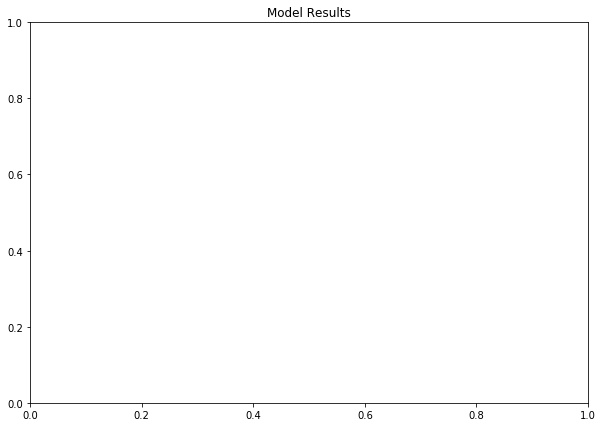

In [36]:
plt.figure(figsize=(10, 7))
plt.title("Model Results")

x = log_1_recall, tree_1_recall, forest_2_recall, knn_2_recall
y = range(1, 100)

plt.bar(x, y)
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('Churn Rate')
plt.legend()